In [1]:
from utils.data_handling import *
from utils.sensor_optimisation_gpy_sparse import *
from parameters import *
import GPy

import sklearn.decomposition
import scipy
import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

from tqdm import tqdm

In [2]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

  0%|          | 0/1 [00:00<?, ?it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [4]:
def human_subset(loc_df, h):
    
    
    human_selection = []
    return human_selection

In [8]:
main_df = loc_df.copy()

In [9]:
delta_s = 1
delta_l = 10
x_bins = list(range(-360,-100,delta_l)) + list(range(-100+delta_s,100-delta_s,delta_s)) + list(range(100,360,delta_l))
y_bins = list(range(-360,-150,delta_l)) + list(range(-150+delta_s,150-delta_s,delta_s)) + list(range(150,360,delta_l))



In [10]:
main_df.loc[:,'Xr'] = pd.cut(main_df.loc[:,'X'],bins=x_bins)
main_df.loc[:,'Yr'] = pd.cut(main_df.loc[:,'Y'],bins=y_bins)
min_surface = main_df.groupby(['Xr','Yr']).min().loc[:,['Z']]
min_surface.loc[:,'X'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['X']]
min_surface.loc[:,'Y'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['Y']]
min_surface.head()

Z           X           Y
Xr           Yr                                       
(-360, -350] (-360, -350]  NaN         NaN         NaN
             (-350, -340]  NaN         NaN         NaN
             (-340, -330]  0.2 -357.124103 -338.123650
             (-330, -320]  0.2 -356.609641 -322.999235
             (-320, -310]  0.2 -356.828699 -315.533727

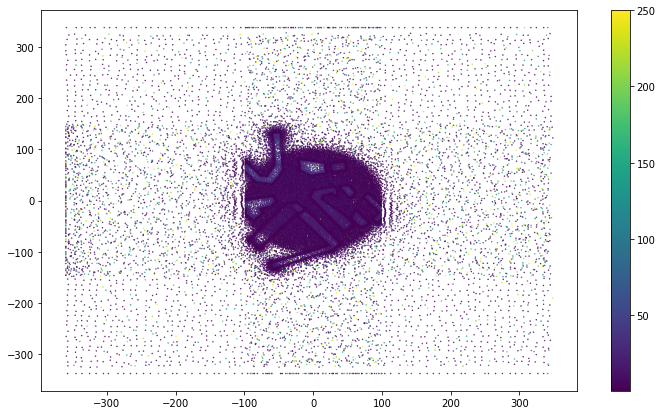

In [11]:
plt.figure(figsize=(12,7))
plt.scatter(min_surface.X, min_surface.Y,c=min_surface.Z, s=0.2)
plt.colorbar()

In [12]:
min_surface.Z.max()

250.0

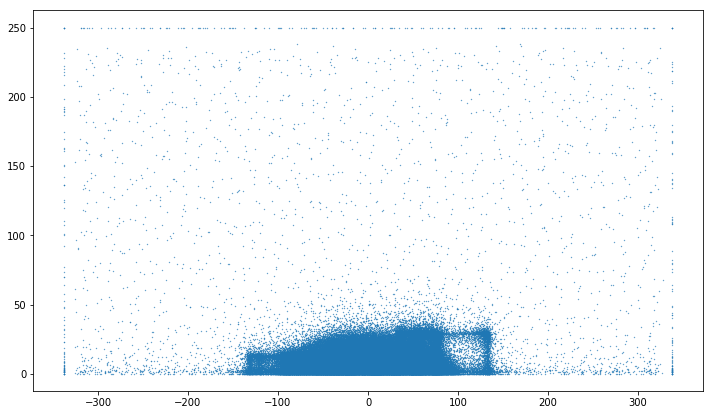

In [13]:
plt.figure(figsize=(12,7))
cond = ( -100 <= loc_df.X) & (loc_df.X <= 100)
plt.scatter(loc_df.Y[cond],loc_df.Z[cond],s=0.1)

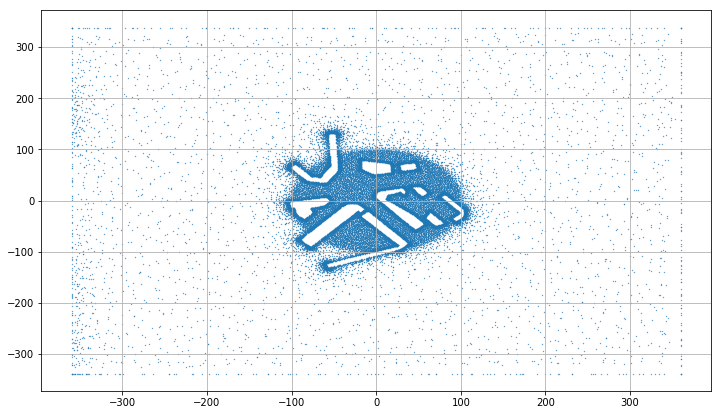

In [14]:
plt.figure(figsize=(12,7))
cond = (loc_df.Z <= 5)
plt.scatter(loc_df.X[cond],loc_df.Y[cond],s=0.1)
plt.grid()

In [15]:
np.sum(cond)

33296

In [16]:
def set_to_onehot(A,n):
    """Function that maps a list of points to a one hot encoding of selected points"""
    A_list = np.zeros((n,1))
    A_list[A] = 1
    return A_list

In [271]:
A_list = set_to_onehot(A,data_df.shape[0])
save_vtu(ref_vtu[0],'WorkingSelection10-4.vtu',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:07:08-17:41:27_WorkingSelection10-4.vtu


In [ ]:
list(range(-360,-100,delta_l)) + list(range(-100+delta_s,100-delta_s,delta_s))

In [17]:
main_df = loc_df.copy()

In [18]:
main_df.loc[:,'theta'] = np.arctan2(main_df.loc[:,'Y'], main_df.loc[:,'X'])
main_df.loc[:,'R'] = np.sqrt(main_df.loc[:,'X']**2  + main_df.loc[:,'Y']**2)
main_df.head()

,X,Y,Z,theta,R
0,-359.684633,-338.12365,250.0,-2.387083,493.660448
1,359.684633,-338.12365,250.0,-0.754510,493.660448
2,359.684633,338.12365,250.0,0.754510,493.660448
3,-359.684633,338.12365,250.0,2.387083,493.660448
4,7.701944,-338.12365,250.0,-1.548022,338.211358


In [19]:
rbin = list(range(0,110,4)) + list(range(110+1,170,30)) + list(range(170+1,494,30))

In [35]:
main_df.loc[:,'Rr'] = pd.cut(main_df.loc[:,'R'],bins=rbin)
main_df.loc[:,'thetar'] = pd.cut(main_df.loc[:,'theta'],bins=180)
min_surface = main_df.groupby(['Rr','thetar']).min().loc[:,['Z']]
min_surface.loc[:,'X'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['X']]
min_surface.loc[:,'Y'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['Y']]
min_surface.head()

Z        X         Y
Rr     thetar                                        
(0, 4] (-3.148, -3.107]        NaN      NaN       NaN
       (-3.107, -3.072]        NaN      NaN       NaN
       (-3.072, -3.037]  19.012789 -3.94955 -0.414791
       (-3.037, -3.002]        NaN      NaN       NaN
       (-3.002, -2.967]        NaN      NaN       NaN

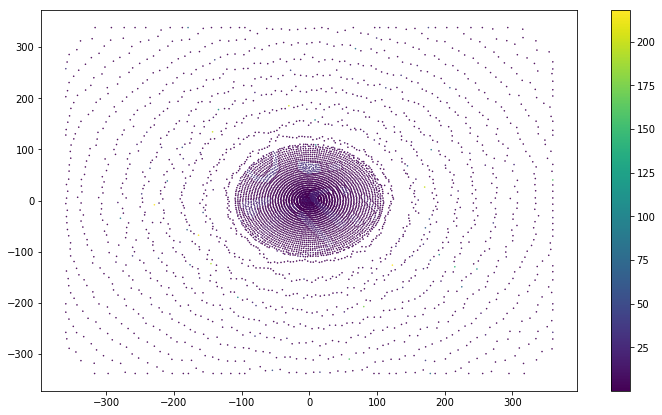

In [36]:
plt.figure(figsize=(12,7))
plt.scatter(min_surface.X, min_surface.Y,c=min_surface.Z, s=0.3)
plt.colorbar()

In [37]:
min_surface.loc[min_surface.Z.idxmax()]


Z    217.895829
X   -228.804563
Y     -8.237856
Name: ((201, 231], (-3.107, -3.072]), dtype: float64

In [30]:
def human_subset_radius(loc_df, h):
    main_df = loc_df.copy()
    
    
    main_df.loc[:,'theta'] = np.arctan2(main_df.loc[:,'Y'], main_df.loc[:,'X'])
    main_df.loc[:,'R'] = np.sqrt(main_df.loc[:,'X']**2  + main_df.loc[:,'Y']**2)
    main_df.head()
    
    rbin = list(range(0,110,4)) + list(range(110+1,170,30)) + list(range(170+1,494,30))

    main_df.loc[:,'Rr'] = pd.cut(main_df.loc[:,'R'],bins=rbin)
    main_df.loc[:,'thetar'] = pd.cut(main_df.loc[:,'theta'],bins=90)
    min_surface = main_df.groupby(['Rr','thetar']).min().loc[:,['Z']].rename(columns={'Z':'Zmin'})
    min_surface.loc[:,'X'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['X']]
    min_surface.loc[:,'Y'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['Y']]
    min_surface.loc[:,'indices'] = main_df.groupby(['Rr','thetar']).apply(lambda x : np.array(x.index.to_list()))
    min_surface.head()

    min_surface.loc[:,'indices_filtered'] = min_surface.apply(lambda x : np.array(main_df.loc[x['indices'],:].loc[main_df.Z <= x['Zmin'] + h].index.to_list()), axis=1)
    human_selection = np.hstack(min_surface.loc[:,'indices_filtered'].values)
    print('The remaining number of points is : ',len(human_selection))

    return human_selection

In [39]:
main_df = loc_df.copy()

In [40]:
delta_s = 1
delta_l = 10
x_bins = list(range(-360,-100,delta_l)) + list(range(-100+delta_s,100-delta_s,delta_s)) + list(range(100,360,delta_l))
y_bins = list(range(-360,-150,delta_l)) + list(range(-150+delta_s,150-delta_s,delta_s)) + list(range(150,360,delta_l))



In [55]:
main_df.loc[:,'Xr'] = pd.qcut(main_df.loc[:,'X'],q=42)
main_df.loc[:,'Yr'] = pd.qcut(main_df.loc[:,'Y'],q=42)
min_surface = main_df.groupby(['Xr','Yr']).min().loc[:,['Z']]
min_surface.loc[:,'X'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['X']]
min_surface.loc[:,'Y'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['Y']]
min_surface.head()

Z           X           Y
Xr                   Yr                                               
(-359.686, -272.207] (-338.125, -219.61]   0.2 -329.791560 -285.633303
                     (-219.61, -129.295]   0.2 -331.707161 -172.653883
                     (-129.295, -103.006]  0.2 -327.630649 -115.754762
                     (-103.006, -89.517]   0.2 -335.661789  -95.777579
                     (-89.517, -80.369]    0.2 -325.762859  -83.520098

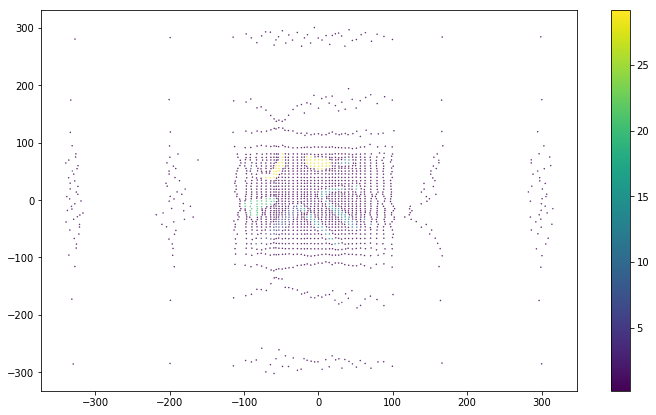

In [56]:
plt.figure(figsize=(12,7))
plt.scatter(min_surface.X, min_surface.Y,c=min_surface.Z, s=0.2)
plt.colorbar()

In [57]:
min_surface.Z.max()

29.165911784265575

In [63]:
def human_subset(loc_df, h):
    main_df = loc_df.copy()
    
    main_df.loc[:,'Xr'] = pd.qcut(main_df.loc[:,'X'],q=42)
    main_df.loc[:,'Yr'] = pd.qcut(main_df.loc[:,'Y'],q=42)
    min_surface = main_df.groupby(['Xr','Yr']).min().loc[:,['Z']].rename(columns={'Z':'Zmin'})
    min_surface.loc[:,'X'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['X']]
    min_surface.loc[:,'Y'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['Y']]

    min_surface.loc[:,'indices'] = main_df.groupby(['Xr','Yr']).apply(lambda x : np.array(x.index.to_list()))

    min_surface.loc[:,'indices_filtered'] = min_surface.apply(lambda x : np.array(main_df.loc[x['indices'],:].loc[main_df.Z <= x['Zmin'] + h].index.to_list()), axis=1)
    human_selection = np.hstack(min_surface.loc[:,'indices_filtered'].values)
    print('The remaining number of points is : ',len(human_selection))

    return human_selection

In [64]:
A_human = human_subset(loc_df,h=3)

The remaining number of points is :  28768


In [17]:
main_df = loc_df.copy()

In [18]:
main_df.loc[:,'theta'] = np.arctan2(main_df.loc[:,'Y'], main_df.loc[:,'X'])
main_df.loc[:,'R'] = np.sqrt(main_df.loc[:,'X']**2  + main_df.loc[:,'Y']**2)
main_df.head()

,X,Y,Z,theta,R
0,-359.684633,-338.12365,250.0,-2.387083,493.660448
1,359.684633,-338.12365,250.0,-0.754510,493.660448
2,359.684633,338.12365,250.0,0.754510,493.660448
3,-359.684633,338.12365,250.0,2.387083,493.660448
4,7.701944,-338.12365,250.0,-1.548022,338.211358


In [19]:
main_df.loc[:,'Rr'] = pd.qcut(main_df.loc[:,'R'],q=22)
main_df.loc[:,'thetar'] = pd.qcut(main_df.loc[:,'theta'],q=180)
min_surface = main_df.groupby(['Rr','thetar']).min().loc[:,['Z']].rename(columns={'Z':'Zmin'})
min_surface.loc[:,'X'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['X']]
min_surface.loc[:,'Y'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['Y']]
min_surface.loc[:,'indices'] = main_df.groupby(['Rr','thetar']).apply(lambda x : np.array(x.index.to_list()))
min_surface.head()

Zmin          X         Y  \
Rr              thetar                                            
(0.125, 21.673] (-3.143, -3.109]  0.200000 -13.290895 -0.189093   
                (-3.109, -3.067]  1.020481 -16.548420 -0.942648   
                (-3.067, -3.022]  0.200000 -12.796983 -1.261028   
                (-3.022, -2.991]  0.200000 -16.047983 -2.146112   
                (-2.991, -2.971]  1.832989 -15.952448 -2.601022   

                                                                            indices  
Rr              thetar                                                               
(0.125, 21.673] (-3.143, -3.109]  [9656, 20999, 24005, 24139, 26561, 28460, 3033...  
                (-3.109, -3.067]  [2439, 7038, 26219, 35970, 46005, 46039, 48729...  
                (-3.067, -3.022]  [9657, 16203, 16485, 18800, 21844, 33060, 3611...  
                (-3.022, -2.991]  [5065, 8774, 10833, 15881, 16076, 16204, 16205...  
                (-2.991, -2.971]  [33414, 36472, 40572, 40606, 45554, 46845, 505...

In [20]:
min_surface.loc[:,'indices_filtered'] = min_surface.apply(lambda x : np.array(main_df.loc[x['indices'],:].loc[main_df.Z < x['Zmin'] + 2].index.to_list()), axis=1)
np.hstack(min_surface.loc[:,'indices_filtered'].values).shape

TypeError: ("cannot do label indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [nan] of <class 'float'>", 'occurred at index ((74.879, 78.534], (2.546, 2.563])')

In [ ]:
plt.figure(figsize=(20,18))
plt.scatter(min_surface.
            X, min_surface.Y,c=min_surface.Zmin, s=0.9)
plt.colorbar()

In [358]:
min_surface.Zmin.max()
min_surface.loc[min_surface.Zmin.idxmax()]


Zmin              34.1258
X                -61.9037
Y                 45.5008
indices    [97537, 99380]
Name: ((74.879, 78.534], (2.496, 2.513]), dtype: object

In [ ]:
main_df.loc[:,'Rr'] = pd.qcut(main_df.loc[:,'R'],q=22)
main_df.loc[:,'thetar'] = pd.qcut(main_df.loc[:,'theta'],q=120)

In [62]:
def human_subset(loc_df, h):
    main_df = loc_df.copy()
    
    main_df.loc[:,'theta'] = np.arctan2(main_df.loc[:,'Y'], main_df.loc[:,'X'])
    main_df.loc[:,'R'] = np.sqrt(main_df.loc[:,'X']**2  + main_df.loc[:,'Y']**2)

    main_df.loc[:,'Rr'] = pd.qcut(main_df.loc[:,'R'],q=100)
    main_df.loc[:,'thetar'] = pd.qcut(main_df.loc[:,'theta'],q=180)
    min_surface = main_df.groupby(['Rr','thetar']).min().loc[:,['Z']].rename(columns={'Z':'Zmin'})
    min_surface.loc[:,'X'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['X']]
    min_surface.loc[:,'Y'] = main_df.groupby(['Rr','thetar']).mean().loc[:,['Y']]
    min_surface.loc[:,'indices'] = main_df.groupby(['Rr','thetar']).apply(lambda x : np.array(x.index.to_list()))
    min_surface = min_surface.dropna()

    min_surface.loc[:,'indices_filtered'] = min_surface.apply(lambda x : np.array(main_df.loc[x['indices'],:].loc[main_df.Z <= x['Zmin'] + h].index.to_list()), axis=1)
    human_selection = np.hstack(min_surface.loc[:,'indices_filtered'].values)
    print('The remaining number of points is : ',len(human_selection))
    
    plt.figure(figsize=(12,7))
    plt.scatter(min_surface.X, min_surface.Y,c=min_surface.Zmin, s=0.2)
    plt.colorbar()

    return human_selection

The remaining number of points is :  44849


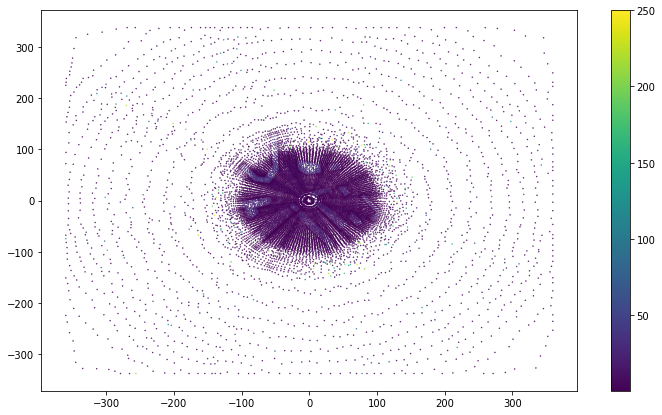

In [63]:
A_human = human_subset(loc_df,h=5)

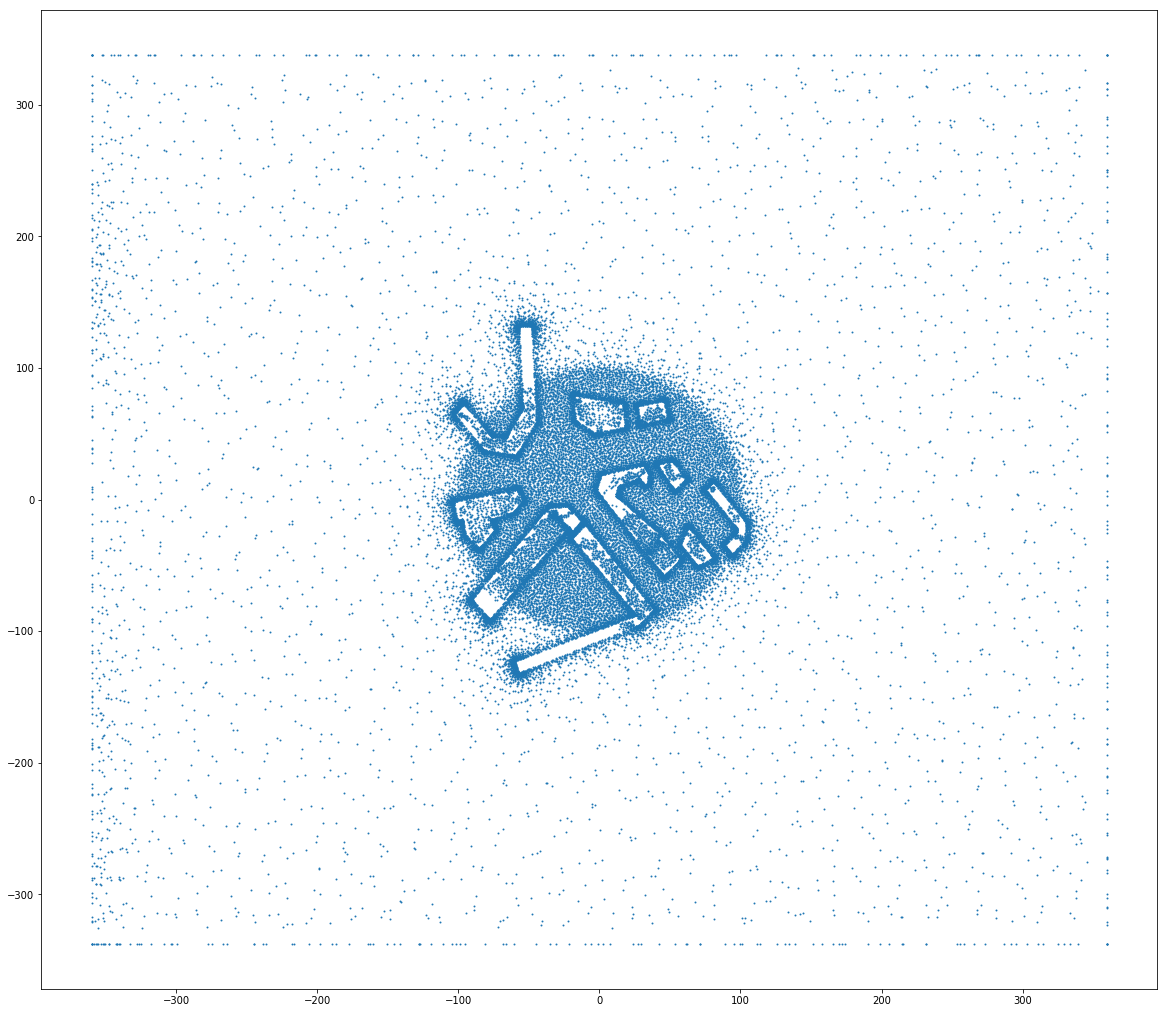

In [57]:
plt.figure(figsize=(20,18))
plt.scatter(loc_df.loc[A_human,'X'].values, loc_df.loc[A_human,'Y'].values, s=0.9)


In [378]:
A_list = set_to_onehot(A_human,data_df.shape[0])
save_vtu(ref_vtu[0],'HumanSelection3',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:07:20-20:30:45_HumanSelection3.vtu


In [26]:
A_human

array([20999, 28460, 30337, ..., 74130, 75012, 90440])

In [66]:
ref_vtu = ref_vtu[0]

In [74]:
ref_vtu.GetPointPoints(1558)

array([   2,  773, 1032, 2637,  690, 1558,  566])

In [152]:
main_df.loc[:,'Z'].min()

0.20000000298

In [218]:
main_df = loc_df.copy()
main_df = main_df.loc[main_df.Z < 30,:]
    
main_df.loc[:,'theta'] = np.arctan2(main_df.loc[:,'Y'], main_df.loc[:,'X'])
main_df.loc[:,'R'] = np.sqrt(main_df.loc[:,'X']**2  + main_df.loc[:,'Y']**2)

main_df.loc[:,'Zcut'] = main_df.loc[:,'Z']
main_df.loc[main_df.loc[:,'R'] > 140,'Zcut'] = main_df.loc[:,'Z'].min()

main_df.loc[:,'Xr'] = pd.cut(main_df.loc[:,'X'],bins=100)
main_df.loc[:,'Yr'] = pd.cut(main_df.loc[:,'Y'],bins=100)

min_surface = main_df.groupby(['Xr','Yr']).min().loc[:,['Zcut']].rename(columns={'Zcut':'Zmin'})
min_surface.loc[:,'X'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['X']]
min_surface.loc[:,'Y'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['Y']]
min_surface.loc[:,'Z'] = main_df.groupby(['Xr','Yr']).mean().loc[:,['Z']]

min_surface.loc[:,'indices'] = main_df.groupby(['Xr','Yr']).apply(lambda x : np.array(x.index.to_list()))
min_surface = min_surface.dropna()





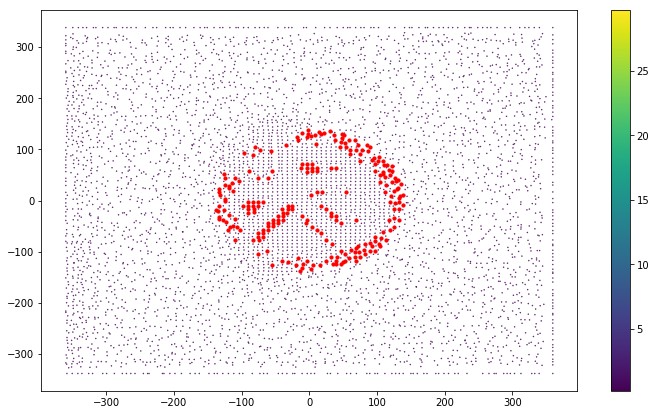

In [219]:
cond = min_surface.Zmin < 35
plt.figure(figsize=(12,7))
plt.scatter(min_surface.X[cond], min_surface.Y[cond],c=min_surface.Zmin[cond], s=0.2)
plt.colorbar()
cond = min_surface.Zmin > 1
plt.scatter(min_surface.X[cond], min_surface.Y[cond],c='r', s=10)


In [211]:
min_surface = min_surface.loc[min_surface.Zmin < 35,:]
h = 2

In [212]:
min_surface.loc[:,'indices_filtered'] = min_surface.apply(lambda x : np.array(main_df.loc[x['indices'],:].loc[main_df.Z <= x['Zmin'] + h].index.to_list()), axis=1)
A_human = np.hstack(min_surface.loc[:,'indices_filtered'].values)
print('The remaining number of points is : ',len(A_human))


The remaining number of points is :  23031


In [229]:
%matplotlib notebook

<IPython.core.display.Javascript object>


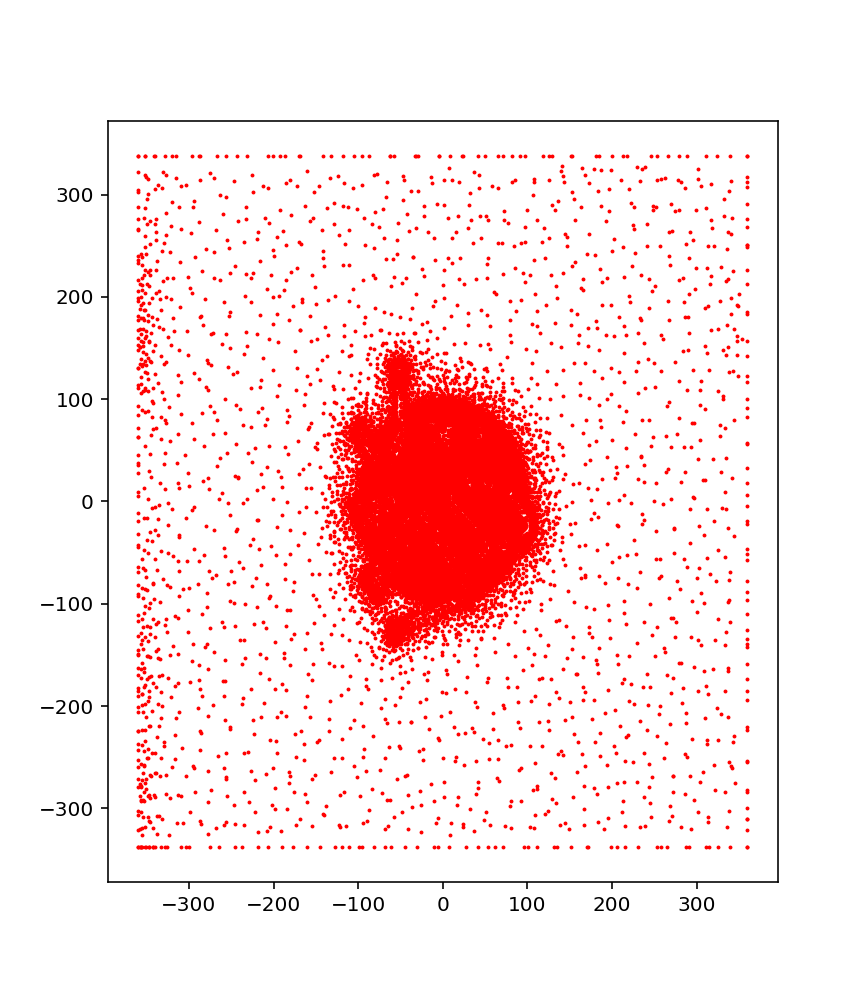

In [234]:
plt.figure(figsize=(6,7))
#plt.scatter(loc_df.loc[loc_df.Z < 30 ,'Z'].values, loc_df.loc[loc_df.Z < 30,'Y'].values, s=0.9)
plt.scatter(loc_df.loc[A_human,'X'].values, loc_df.loc[A_human,'Y'].values, s=0.9,c='r')


In [214]:
A_list = set_to_onehot(A_human,data_df.shape[0])
save_vtu(ref_vtu[0],'HumanSelection3',A_list)

IndexError: arrays used as indices must be of integer (or boolean) type